In [101]:
import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd
import scipy as sklearn

import os

## 학습 시작

In [270]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import random

In [271]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [272]:
trans = transforms.Compose([
    transforms.ToTensor(), #학습을 위해 dataset들을 텐서로 전환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.ImageFolder(root='../input/music-genres-classification/train_mfcc', transform=trans)
test_data = torchvision.datasets.ImageFolder(root='../input/music-genres-classification/test_mfcc', transform=trans)

In [273]:
batch_size = 200
data_loader = DataLoader(dataset = train_data, 
                         batch_size = batch_size, 
                         shuffle = True, 
                         num_workers=2, # 데이터를 빨리 읽어오기 위한것
                         drop_last=True)

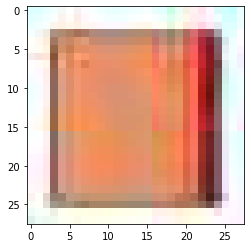

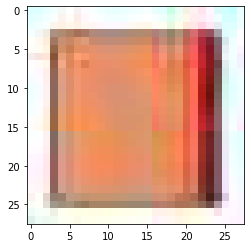

In [274]:
import matplotlib.pyplot as plt
# plt.imshow(data_loader.dataset[0][0].numpy().reshape((28,28,3)))
plt.imshow(data_loader.dataset[0][0].numpy().transpose(2,1,0)) ## 3,28,28 -> 28,28,3
plt.show() #normal을해서 원본사진과 색의 차이가 있슴
plt.imshow(torch.transpose(data_loader.dataset[0][0], 2, 0)) 
plt.show()
# print(data_loader.dataset[0][0].numpy())

In [275]:
test_set = DataLoader(dataset = test_data, 
                      batch_size = len(test_data),
                      shuffle=False)

In [366]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 128, bias=True),
            nn.ReLU(),
#             nn.Dropout(p=0.3),
            nn.Linear(128, 10, bias=True)
        )
        
        torch.nn.init.xavier_uniform_(self.fc[0].weight)
        torch.nn.init.xavier_uniform_(self.fc[2].weight)
        
    def forward(self, x):
        return self.fc(self.layer2(self.layer1(x)).view(-1, 64*7*7))

In [374]:
model = MyModel().to(device)

In [375]:
loss = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [376]:
total_batch = len(data_loader)
model.train()
for epoch in range(50+1):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        # one-hot encoding되어 있지 않음
        Y = Y.to(device)
      
        optimizer.zero_grad()
        hypothesis = model(X) #forward 계산
        cost = loss(hypothesis, Y) #cost
        cost.backward() #backpropagation
        optimizer.step() #갱신

        avg_cost += cost / total_batch #평균 error
    if epoch % 5==0:
        print('Epoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost,))
            

print('Learning finished')

Epoch: 0000 cost = 3.851396322
Epoch: 0005 cost = 2.116593122
Epoch: 0010 cost = 1.991128922
Epoch: 0015 cost = 1.738538980
Epoch: 0020 cost = 1.559803009
Epoch: 0025 cost = 1.560805559
Epoch: 0030 cost = 1.463673115
Epoch: 0035 cost = 1.388425350
Epoch: 0040 cost = 1.356221437
Epoch: 0045 cost = 1.305153131
Epoch: 0050 cost = 1.247496247
Learning finished


## 성능 계산

In [378]:
with torch.no_grad():
    model.eval()
    for _, data in enumerate(test_set):
        imgs, label = data
#                 print(len(imgs), len(label))
        imgs = imgs.to(device)
        label = label.to(device)

        prediction = model(imgs)

        correct_prediction = torch.argmax(prediction, 1) == label

        accuracy = correct_prediction.float().mean()
        print(accuracy.item())

0.3834586441516876


In [381]:
submit=pd.read_csv('../input/music-genres-classification/submition_form.csv')

In [382]:
submit['label'] = torch.argmax(prediction, 1).cpu().numpy()
submit.to_csv('submission.csv',index=False, header=True)

In [383]:
submit

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
128,128,9
129,129,5
130,130,9
131,131,6
